# deskripsi library yang digunakan 


In [9]:
import pandas as pd
import numpy as np

# library untuk visualisasi
import matplotlib.pyplot as plt
import seaborn as sns

# library untuk analisis time series
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

#library yang digunakan untuk forecasting
from statsmodels.tsa.holtwinters import SimpleExpSmoothing, ExponentialSmoothing
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error

## memanggil dataset


In [11]:
df = pd.read_excel('CO2 dataset.xlsx')

## deskripsi dataset

In [12]:
df.head()

,Year,CO2
0,1800,0.00568
1,1801,0.00561
2,1802,0.00555
3,1803,0.00548
4,1804,0.00542


In [13]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 215 entries, 0 to 214
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Year    215 non-null    int64  
 1   CO2     215 non-null    float64
dtypes: float64(1), int64(1)
memory usage: 3.5 KB


## transform data

In [14]:
df['Year'] = pd.to_datetime(df['Year'], format='%Y')

In [15]:
df.set_index(['Year'], inplace=True)

In [16]:
df.head()

,CO2
Year,
1800-01-01,0.00568
1801-01-01,0.00561
1802-01-01,0.00555
1803-01-01,0.00548
1804-01-01,0.00542


In [18]:
df.index.min(), df.index.max()

(Timestamp('1800-01-01 00:00:00'), Timestamp('2014-01-01 00:00:00'))

In [20]:
if (df.index.max() - df.index.min() == 214):
    print ('Data is Continous')


In [22]:
df.index.freq = 'YS'

# ANALISA TIME SERIES

<Axes: xlabel='Year'>

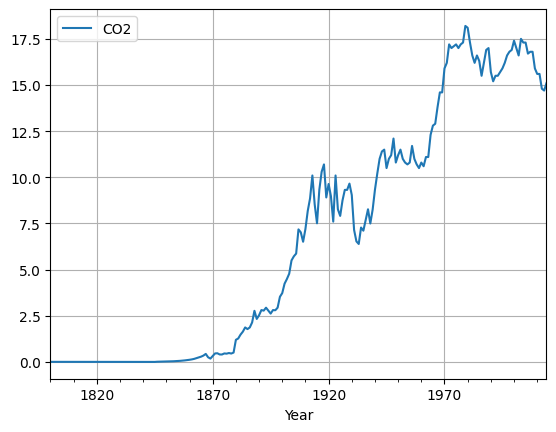

In [23]:
df.plot(grid=True)

In [24]:
train_df = df.loc[:'1991-01-01']
test_df = df.loc['1992-01-01':]

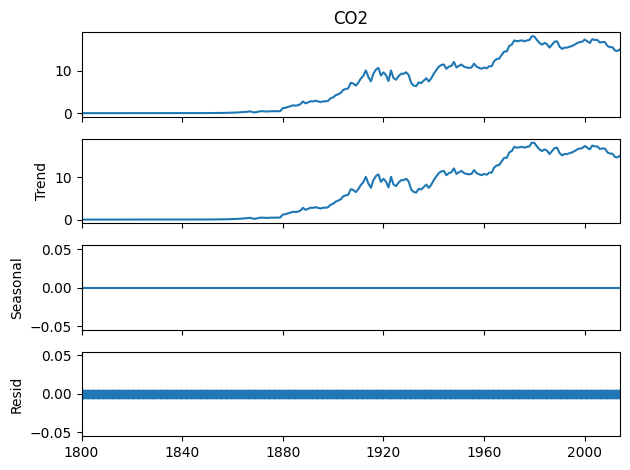

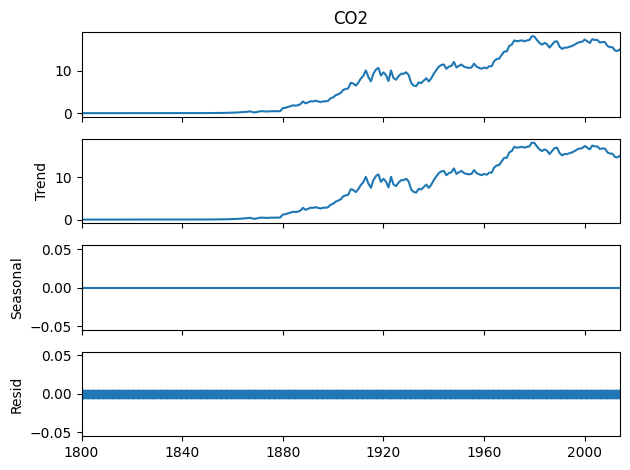

In [26]:
decompose_add = seasonal_decompose(df['CO2'])
decompose_add.plot()

In [28]:
def adf_test(timeseries):
    print ('Hasil testing Dickey-Fuller')
    print ('-----------------------------------')
    adftest = adfuller(timeseries)
    adf_output = pd.Series(adftest[0:4], index=['Tedt statistic', 'p-value','Lags Used','Number of Observation Used'])
    for key,Value in adftest[4].items() :
        adf_output['Critical Value (%s)' %key] = Value
    print (adf_output)
    
adf_test(df.values)

Hasil testing Dickey-Fuller
-----------------------------------
Tedt statistic                 -0.378463
p-value                         0.913633
Lags Used                       0.000000
Number of Observation Used    214.000000
Critical Value (1%)            -3.461282
Critical Value (5%)            -2.875143
Critical Value (10%)           -2.574020
dtype: float64


In [29]:
diff_df = df.diff()
diff_df.head()

,CO2
Year,
1800-01-01,NaN
1801-01-01,-0.00007
1802-01-01,-0.00006
1803-01-01,-0.00007
1804-01-01,-0.00006


In [30]:
diff_df.dropna(inplace=True)

<Axes: xlabel='Year'>

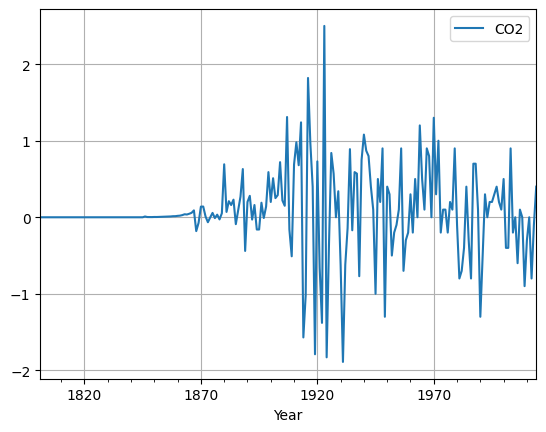

In [31]:
diff_df.plot(grid=True)

In [33]:
adf_test(diff_df)

Hasil testing Dickey-Fuller
-----------------------------------
Tedt statistic                 -3.780005
p-value                         0.003119
Lags Used                      15.000000
Number of Observation Used    198.000000
Critical Value (1%)            -3.463815
Critical Value (5%)            -2.876251
Critical Value (10%)           -2.574611
dtype: float64


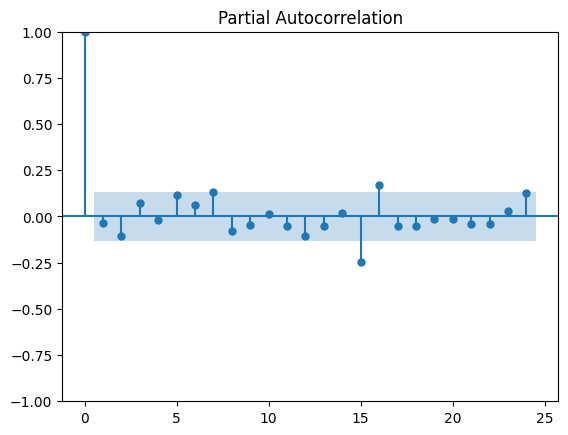

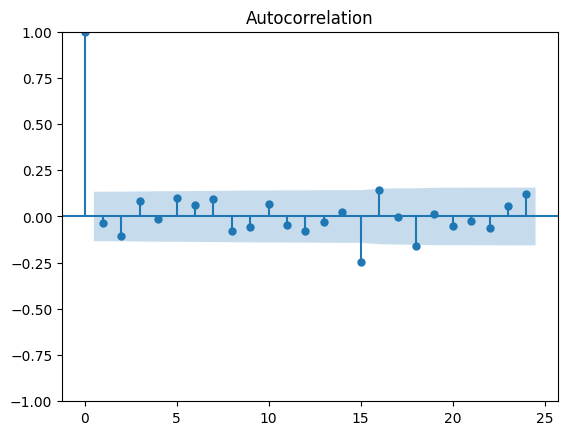

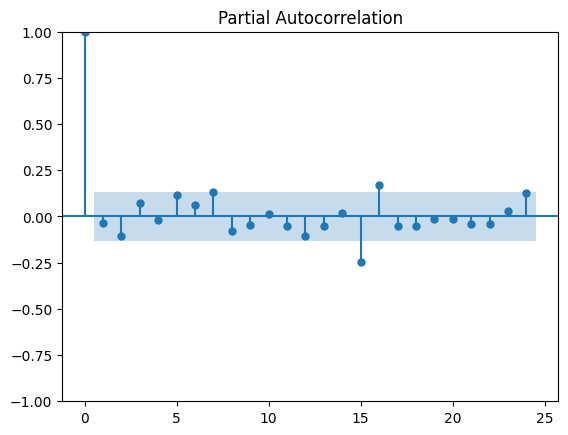

In [34]:
plot_acf(diff_df)
plot_pacf(diff_df)

## single exponensial Smooth

In [35]:
single_exp = SimpleExpSmoothing(train_df).fit()
single_exp_train_pred = single_exp.fittedvalues
single_exp_test_pred = single_exp.forecast(23)

<Axes: xlabel='Year'>

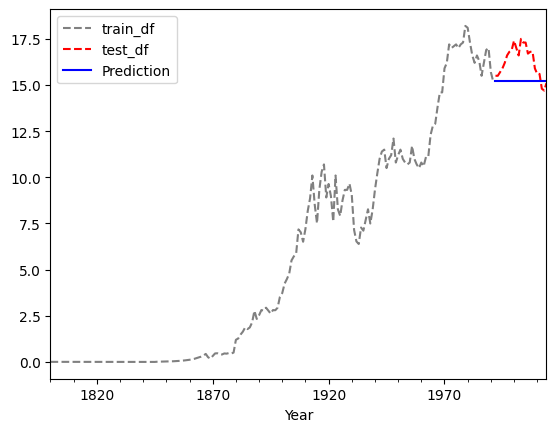

In [36]:
train_df['CO2'].plot(style='--', color='gray', legend=True, label='train_df')
test_df['CO2'].plot(style='--', color='r', legend=True, label='test_df')
single_exp_test_pred.plot(color='b', legend=True, label='Prediction')

In [37]:
print('Train RMSE :',mean_squared_error(train_df, single_exp_train_pred)**0.5)
print('Test RMSE :', mean_squared_error(test_df, single_exp_test_pred)**0.5)
print('Train MAPE :', mean_absolute_percentage_error(train_df, single_exp_train_pred))
print('Test MAPE :', mean_absolute_percentage_error(test_df, single_exp_test_pred))

Train RMSE : 0.564692002680021
Test RMSE : 1.3429113022690744
Train MAPE : 0.08470457297144991
Test MAPE : 0.06861466412071275


## Double exponensial Smoothing


In [38]:
double_exp = ExponentialSmoothing(train_df, trend=None, initialization_method='heuristic',seasonal='add', seasonal_periods=19, damped_trend=False).fit()
double_exp_train_pred = double_exp.fittedvalues
double_exp_test_pred = double_exp.forecast(23)


<Axes: xlabel='Year'>

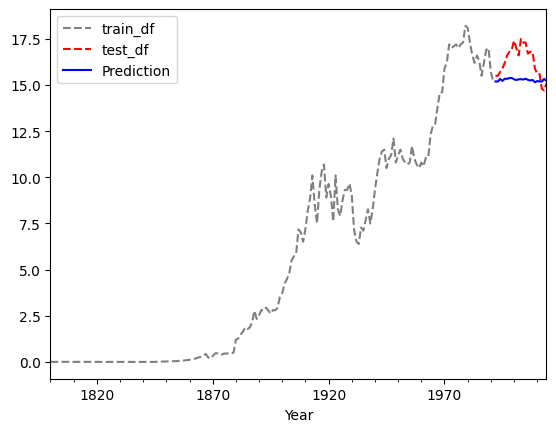

In [39]:
train_df['CO2'].plot(style='--', color='gray', legend=True, label='train_df')
test_df['CO2'].plot(style='--', color='r', legend=True, label='test_df')
double_exp_test_pred.plot(color='b', legend=True, label='Prediction')

In [40]:
print('Train RMSE :',mean_squared_error(train_df, double_exp_train_pred)**0.5)
print('Test RMSE :', mean_squared_error(test_df, double_exp_test_pred)**0.5)
print('Train MAPE :', mean_absolute_percentage_error(train_df, double_exp_train_pred))
print('Test MAPE :', mean_absolute_percentage_error(test_df, double_exp_test_pred))

Train RMSE : 0.5623542487428108
Test RMSE : 1.274508812795847
Train MAPE : 2.3566276596305555
Test MAPE : 0.06557014292834698


## ARIMA 